In [141]:
!pip install inflection

In [143]:
import inflection

In [144]:
import joblib
import warnings

import numpy             as np
import pandas            as pd
import seaborn           as sns

import matplotlib.pyplot as plt

from scipy   import stats
from boruta  import BorutaPy
from category_encoders import OneHotEncoder

from IPython.display      import Image
from IPython.core.display import HTML 

from xgboost  import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.svm          import SVC
from sklearn.dummy        import DummyClassifier
from sklearn.ensemble     import RandomForestClassifier
from sklearn.neighbors    import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics         import balanced_accuracy_score, precision_score, classification_report
from sklearn.metrics         import recall_score, f1_score, make_scorer, cohen_kappa_score
from sklearn.preprocessing   import MinMaxScaler
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold

## 0.2 Helper Functions

In [145]:
warnings.filterwarnings('ignore')

seed = 42
np.random.seed(seed)

In [146]:
def jupyter_settings():
    %matplotlib inline
    
    sns.set(font_scale=1.6)
    
    plt.style.use('seaborn-darkgrid')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 16
    
    display(HTML('<style>.container { width:100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
jupyter_settings()

In [147]:
def ml_scores(model_name, y_true, y_pred):
    
    accuracy = balanced_accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)
    
    return pd.DataFrame({'Balanced Accuracy': np.round(accuracy, 3), 
                         'Precision': np.round(precision, 3), 
                         'Recall': np.round(recall, 3),
                         'F1': np.round(f1, 3),
                         'Kappa': np.round(kappa, 3)}, 
                        index=[model_name])

In [148]:
def calcCramerV(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = stats.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))

In [149]:
def ml_cv_results(model_name, model, x, y, verbose=1):
    
    '''initial'''
    balanced_accuracies = []
    precisions = []
    recalls = []
    f1s = []
    kappas = []
    
    mm = MinMaxScaler()
    
    x_ = x.to_numpy()
    y_ = y.to_numpy()
    
    count = 0
    
    '''cross-validation'''
    skf = StratifiedKFold(n_splits=5, shuffle=True)
    
    for index_train, index_test in skf.split(x_, y_):
        ## Showing the Fold
        if verbose > 0:
            count += 1
            print('Fold K=%i' % (count))
    
        ## selecting train and test
        x_train, x_test = x.iloc[index_train], x.iloc[index_test]
        y_train, y_test = y.iloc[index_train], y.iloc[index_test]
        
        ## applying the scale
        x_train = mm.fit_transform(x_train)
        x_test = mm.transform(x_test)
    
        ## training the model
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)

        ## saving the metrics
        balanced_accuracies.append(balanced_accuracy_score(y_test, y_pred))
        precisions.append(precision_score(y_test, y_pred))
        recalls.append(recall_score(y_test, y_pred))
        f1s.append(f1_score(y_test, y_pred))
        kappas.append(cohen_kappa_score(y_test, y_pred))
        
        
    '''results'''    
    accuracy_mean, accuracy_std = np.round(np.mean(balanced_accuracies), 3), np.round(np.std(balanced_accuracies), 3)
    precision_mean, precision_std = np.round(np.mean(precisions), 3), np.round(np.std(precisions), 3)
    recall_mean, recall_std = np.round(np.mean(recalls), 3), np.round(np.std(recalls), 3)
    f1_mean, f1_std = np.round(np.mean(f1s), 3), np.round(np.std(f1s), 3)
    kappa_mean, kappa_std = np.round(np.mean(kappas), 3), np.round(np.std(kappas), 3)
    
    ## saving the results in a dataframe
    return pd.DataFrame({"Balanced Accuracy": "{} +/- {}".format(accuracy_mean, accuracy_std),
                        "Precision": "{} +/- {}".format(precision_mean, precision_std),
                        "Recall": "{} +/- {}".format(recall_mean, recall_std),
                        "F1": "{} +/- {}".format(f1_mean, f1_std),
                        "Kappa": "{} +/- {}".format(kappa_mean, kappa_std)},
                       index=[model_name])

# 1.0 Data Description

In [150]:
df1 = pd.read_csv('/kaggle/input/credit-card-transactions-labeled-data/fraud_0.1origbase.csv')
# todo: change naming

In [151]:
df1.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,283,CASH_IN,210329.84,C1159819632,3778062.79,3988392.64,C1218876138,1519266.60,1308936.76,0,0
1,132,CASH_OUT,215489.19,C1372369468,21518.00,0.00,C467105520,6345756.55,6794954.89,0,0
2,355,DEBIT,4431.05,C1059822709,20674.00,16242.95,C76588246,80876.56,85307.61,0,0
3,135,CASH_OUT,214026.20,C1464960643,46909.73,0.00,C1059379810,13467450.36,13681476.56,0,0
4,381,CASH_OUT,8858.45,C831134427,0.00,0.00,C579876929,1667180.58,1676039.03,0,0


In [152]:
df1.tail()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
636257,351,CASH_OUT,28761.10,C742050657,0.0,0.00,C568407561,328534.52,357295.62,0,0
636258,184,CASH_OUT,167820.71,C561181412,62265.0,0.00,C1852953580,106429.48,274250.18,0,0
636259,35,PAYMENT,8898.12,C1773417333,30808.0,21909.88,M445701551,0.00,0.00,0,0
636260,277,CASH_OUT,176147.90,C1423233247,83669.0,0.00,C1328739120,0.00,176147.90,0,0
636261,304,CASH_OUT,95142.89,C874575079,0.0,0.00,C666451134,431380.07,526522.96,0,0


## 1.2 Columns

### 1.2.1 Column Descriptions

**step:** maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

**type:** CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

**amount:** amount of the transaction in local currency.

**nameOrig:** customer who started the transaction

**oldbalanceOrg:** initial balance before the transaction

**newbalanceOrig:** new balance after the transaction

**nameDest:** customer who is the recipient of the transaction

**oldbalanceDest:** initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

**newbalanceDest:** new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

**isFraud:** This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

**isFlaggedFraud:** The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

### 1.2.2 Column Rename

In [153]:
cols_old = df1.columns.tolist()

snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))

df1.columns = cols_new

In [154]:
df1.columns

Index(['step', 'type', 'amount', 'name_orig', 'oldbalance_org',
       'newbalance_orig', 'name_dest', 'oldbalance_dest', 'newbalance_dest',
       'is_fraud', 'is_flagged_fraud'],
      dtype='object')

## 1.3 Data Dimension

print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Cols: {}'.format(df1.shape[1]))

## 1.4 Data Types and Structure

In [155]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636262 entries, 0 to 636261
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   step              636262 non-null  int64  
 1   type              636262 non-null  object 
 2   amount            636262 non-null  float64
 3   name_orig         636262 non-null  object 
 4   oldbalance_org    636262 non-null  float64
 5   newbalance_orig   636262 non-null  float64
 6   name_dest         636262 non-null  object 
 7   oldbalance_dest   636262 non-null  float64
 8   newbalance_dest   636262 non-null  float64
 9   is_fraud          636262 non-null  int64  
 10  is_flagged_fraud  636262 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 53.4+ MB


## 1.5 Check NA

In [156]:
df1.isna().mean()

step                0.0
type                0.0
amount              0.0
name_orig           0.0
oldbalance_org      0.0
newbalance_orig     0.0
name_dest           0.0
oldbalance_dest     0.0
newbalance_dest     0.0
is_fraud            0.0
is_flagged_fraud    0.0
dtype: float64

## 1.7 Change Data Type

I will change the values 0 and 1 to 'yes' and 'no'. It'll help on the data description and analysis sections.

In [157]:
df1['is_fraud'] = df1['is_fraud'].map({1: 'yes', 0: 'no'})
df1['is_flagged_fraud'] = df1['is_flagged_fraud'].map({1: 'yes', 0: 'no'})

In [158]:
num_attributes = df1.select_dtypes(exclude='object')
cat_attributes = df1.select_dtypes(include='object')

### 1.8.1 Numerical Attributes

In [159]:
describe = num_attributes.describe().T

describe['range'] = (num_attributes.max() - num_attributes.min()).tolist()
describe['variation coefficient'] = (num_attributes.std() / num_attributes.mean()).tolist()
describe['skew'] = num_attributes.skew().tolist()
describe['kurtosis'] = num_attributes.kurtosis().tolist()

describe

,count,mean,std,min,25%,50%,75%,max,range,variation coefficient,skew,kurtosis
step,636262.0,2.429319e+02,1.423309e+02,1.0,155.000,238.000,3.340000e+02,7.420000e+02,7.410000e+02,0.585888,0.375052,0.324437
amount,636262.0,1.800585e+05,6.069714e+05,0.0,13407.425,74815.770,2.084988e+05,5.722962e+07,5.722962e+07,3.370967,29.577107,1546.661043
oldbalance_org,636262.0,8.317937e+05,2.885636e+06,0.0,0.000,14239.000,1.072998e+05,4.368662e+07,4.368662e+07,3.469173,5.243428,32.766036
newbalance_orig,636262.0,8.528354e+05,2.921296e+06,0.0,0.000,0.000,1.435652e+05,4.367380e+07,4.367380e+07,3.425393,5.173614,31.932547
oldbalance_dest,636262.0,1.096212e+06,3.375389e+06,0.0,0.000,131539.745,9.384820e+05,3.551855e+08,3.551855e+08,3.079138,20.622388,1074.335293
newbalance_dest,636262.0,1.221809e+06,3.656213e+06,0.0,0.000,214712.725,1.109230e+06,3.555534e+08,3.555534e+08,2.992460,19.623903,928.694204


* All the data has a coeficient of variation greater than 25%, therefore they aren't homogeneous.

* The step variable starts from 1 hour to 742 hour (30 days).

* Some variables are higher shap and right skewed.

* 50% of the newbalance_orig is 0. Maybe there are some transfers that don't go to the destination.

* The skew is higher positive, therefore the values may be in less values.

### 1.8.2 Categorical Attributes

In [160]:
cat_attributes.describe()

,type,name_orig,name_dest,is_fraud,is_flagged_fraud
count,636262,636262,636262,636262,636262
unique,5,636171,457224,2,2
top,CASH_OUT,C334643493,C2083562754,no,no
freq,224216,2,14,635441,636260


* The majority type is cash_out with 2237500.

* There's a lot of variability in name_orig, so it could be hard to use one hot encoding.

* There's less name_orig than name_dest. There's more users sending than receiving, however use one hot encoding will not help.

* There's more fraud than the flagged fraud, it shows that the current method can't recognize fraud efficiently.

# 2.0 Feature Engineering

In [161]:
df2 = df1.copy()

## 2.1 Mind Map 

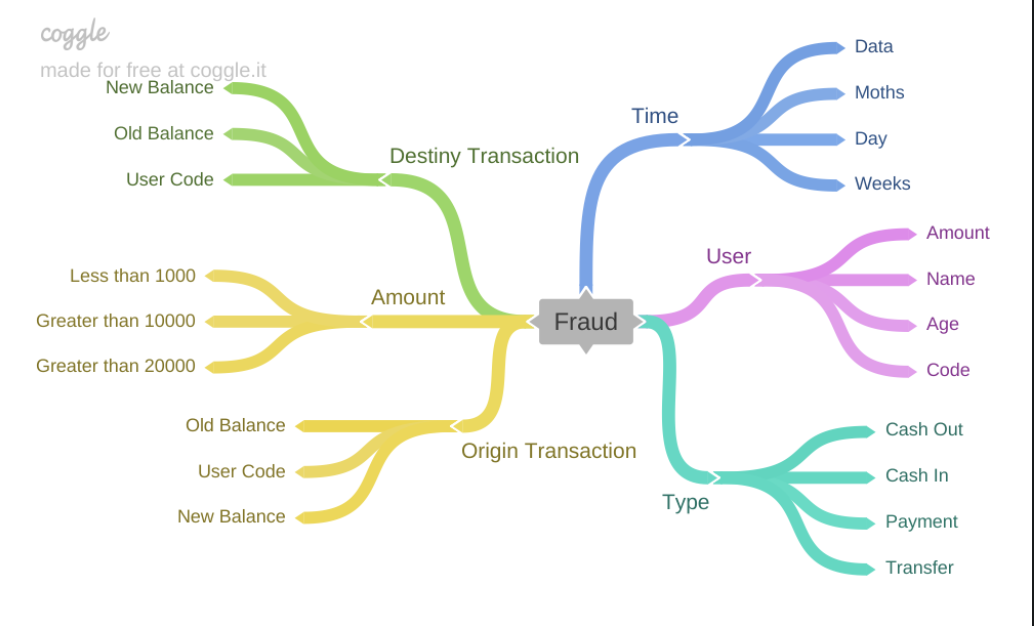

## 2.2 Feature Engineering

In [162]:
# step
df2['step_days'] = df2['step'].apply(lambda i: i/24)
df2['step_weeks'] = df2['step'].apply(lambda i: i/(24*7))

# difference between initial balance before the transaction and new balance after the transaction
df2['diff_new_old_balance'] = df2['newbalance_orig'] - df2['oldbalance_org']

# difference between initial balance recipient before the transaction and new balance recipient after the transaction.
df2['diff_new_old_destiny'] = df2['newbalance_dest'] - df2['oldbalance_dest']

# name orig and name dest
df2['name_orig'] = df2['name_orig'].apply(lambda i: i[0])
df2['name_dest'] = df2['name_dest'].apply(lambda i: i[0])

# 3.0 Selecting Columns and Rows

We will use all available columns and rows for analysis

In [ ]:
df3 = df2.copy()

# 4.0 Exploratory Data Analisys

In [ ]:
df4 = df3.copy()

## 4.1 Univariate Analysis

### 4.1.1 Response Variable

In [ ]:
ax = sns.countplot(y='is_fraud', data=df4);

total = df4['is_fraud'].size
for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

### 4.1.2 Numerical Variables

In [ ]:
num_attributes = df4.select_dtypes(exclude='object')
columns = num_attributes.columns.tolist()
j = 1

for column in columns:
    plt.subplot(2, 5, j)
    sns.distplot(num_attributes[column]);
    
    j += 1

### 4.1.3 Categorical Variables

In [ ]:
cat_attributes = df4.select_dtypes(include='object')
columns = cat_attributes.columns.tolist()
j = 1

for column in columns:
    plt.subplot(3, 2, j)
    ax = sns.countplot(y=column, data=cat_attributes)
    
    total = cat_attributes[column].size
    for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))
    
    j += 1

# 5.0 Data Preparation

## 5.1 Spliting into Train, Valid and Test

In [164]:
df5 = df4.copy()

In [165]:
df5.head()

,step,type,amount,name_orig,oldbalance_org,newbalance_orig,name_dest,oldbalance_dest,newbalance_dest,is_fraud,is_flagged_fraud,step_days,step_weeks,diff_new_old_balance,diff_new_old_destiny
0,283,CASH_IN,210329.84,C,3778062.79,3988392.64,C,1519266.60,1308936.76,no,no,11.791667,1.684524,210329.85,-210329.84
1,132,CASH_OUT,215489.19,C,21518.00,0.00,C,6345756.55,6794954.89,no,no,5.500000,0.785714,-21518.00,449198.34
2,355,DEBIT,4431.05,C,20674.00,16242.95,C,80876.56,85307.61,no,no,14.791667,2.113095,-4431.05,4431.05
3,135,CASH_OUT,214026.20,C,46909.73,0.00,C,13467450.36,13681476.56,no,no,5.625000,0.803571,-46909.73,214026.20
4,381,CASH_OUT,8858.45,C,0.00,0.00,C,1667180.58,1676039.03,no,no,15.875000,2.267857,0.00,8858.45


In [166]:
df5.columns

Index(['step', 'type', 'amount', 'name_orig', 'oldbalance_org',
       'newbalance_orig', 'name_dest', 'oldbalance_dest', 'newbalance_dest',
       'is_fraud', 'is_flagged_fraud', 'step_days', 'step_weeks',
       'diff_new_old_balance', 'diff_new_old_destiny'],
      dtype='object')

In [167]:
X = df5.drop(columns=['is_fraud', 'is_flagged_fraud', 'name_orig', 'name_dest', 
                      'step_weeks', 'step_days'], axis=1)
y = df5['is_fraud'].map({'yes': 1, 'no': 0})

In [168]:
# spliting into temp and test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=.2, stratify=y)

In [169]:
# spliting into train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=.2, stratify=y_temp)

In [170]:
X_train.columns

Index(['step', 'type', 'amount', 'oldbalance_org', 'newbalance_orig',
       'oldbalance_dest', 'newbalance_dest', 'diff_new_old_balance',
       'diff_new_old_destiny'],
      dtype='object')

## 5.2 One Hot Encoder

In [171]:
ohe = OneHotEncoder(cols=['type'], use_cat_names=True)

X_train = ohe.fit_transform(X_train)
X_valid = ohe.transform(X_valid)

X_temp = ohe.fit_transform(X_temp)
X_test = ohe.transform(X_test)

In [172]:
X_test.head()

,step,type_PAYMENT,type_CASH_OUT,type_CASH_IN,type_TRANSFER,type_DEBIT,amount,oldbalance_org,newbalance_orig,oldbalance_dest,newbalance_dest,diff_new_old_balance,diff_new_old_destiny
578630,94,0,0,0,1,0,672901.28,0.00,0.00,8881502.26,10664836.01,0.00,1783333.75
248692,234,0,1,0,0,0,42319.66,0.00,0.00,273167.66,315487.32,0.00,42319.66
43980,231,0,0,0,0,1,5635.52,133346.00,127710.48,45858.49,51494.02,-5635.52,5635.53
331603,358,0,0,1,0,0,156974.98,425464.73,582439.71,1033044.87,876069.89,156974.98,-156974.98
123136,33,0,0,1,0,0,321256.73,10501.00,331757.73,87655.83,0.00,321256.73,-87655.83


## 5.3 Rescaling

In [173]:
num_columns = ['amount', 'oldbalance_org', 'newbalance_orig', 'oldbalance_dest', 'newbalance_dest',
               'diff_new_old_balance', 'diff_new_old_destiny']
mm = MinMaxScaler()
X_params = X_temp.copy()

X_train[num_columns] = mm.fit_transform(X_train[num_columns])
X_valid[num_columns] = mm.transform(X_valid[num_columns])

X_params[num_columns] = mm.fit_transform(X_temp[num_columns])
X_test[num_columns] = mm.transform(X_test[num_columns])

In [174]:
X_test.head()

,step,type_PAYMENT,type_CASH_OUT,type_CASH_IN,type_TRANSFER,type_DEBIT,amount,oldbalance_org,newbalance_orig,oldbalance_dest,newbalance_dest,diff_new_old_balance,diff_new_old_destiny
578630,94,0,0,0,1,0,0.011758,0.000000,0.000000,0.025005,0.030010,0.878805,0.089815
248692,234,0,1,0,0,0,0.000739,0.000000,0.000000,0.000769,0.000888,0.878805,0.070263
43980,231,0,0,0,0,1,0.000098,0.003514,0.003346,0.000129,0.000145,0.878309,0.069851
331603,358,0,0,1,0,0,0.002743,0.011211,0.015260,0.002908,0.002465,0.892600,0.068024
123136,33,0,0,1,0,0,0.005613,0.000277,0.008692,0.000247,0.000000,0.907037,0.068803


# 6.0 Feature Selection

In [175]:
# X_boruta = X_params.values
# y_boruta = y_temp.values.ravel()

In [176]:
# boruta = BorutaPy(RandomForestClassifier(), n_estimators='auto')
# boruta.fit(X_boruta, y_boruta)

### 6.1.1 Best Features

In [177]:
# cols_selected_boruta = boruta.support_.tolist()

In [178]:
# columns_selected = X_params.loc[:, cols_selected_boruta].columns.tolist()

In [179]:
# columns_selected

['step',
 'amount',
 'oldbalance_org',
 'newbalance_orig',
 'oldbalance_dest',
 'newbalance_dest',
 'diff_new_old_balance',
 'diff_new_old_destiny',
 'type_TRANSFER']

In [180]:
final_columns_selected = ['step', 'oldbalance_org', 
                          'newbalance_orig', 'newbalance_dest', 
                          'diff_new_old_balance', 'diff_new_old_destiny', 
                          'type_TRANSFER']

# 7.0 Machine Learning Modeling

In [181]:
X_train_cs = X_train[final_columns_selected]
X_valid_cs = X_valid[final_columns_selected]

X_temp_cs = X_temp[final_columns_selected]
X_test_cs = X_test[final_columns_selected]

X_params_cs = X_params[final_columns_selected]

## 7.1 Baseline

In [182]:
dummy = DummyClassifier()
dummy.fit(X_train_cs, y_train)

y_pred = dummy.predict(X_valid_cs)

In [183]:
dummy_results = ml_scores('dummy', y_valid, y_pred)
dummy_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
dummy,0.5,0.0,0.0,0.0,0.0


### 7.1.1 Classification Report

In [184]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    101671
           1       0.00      0.00      0.00       131

    accuracy                           1.00    101802
   macro avg       0.50      0.50      0.50    101802
weighted avg       1.00      1.00      1.00    101802



### 7.1.2 Cross Validation

In [185]:
dummy_cv = ml_cv_results('Dummy', DummyClassifier(), X_temp, y_temp)
dummy_cv

Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


,Balanced Accuracy,Precision,Recall,F1,Kappa
Dummy,0.5 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0


## 7.2 Logistic Regression

In [186]:
lg = LogisticRegression()
lg.fit(X_train_cs, y_train)

y_pred = lg.predict(X_valid_cs)

In [187]:
lg_results = ml_scores('Logistic Regression', y_valid, y_pred)
lg_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
Logistic Regression,0.588,1.0,0.176,0.299,0.298


### 7.2.1 Classification Report

In [188]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    101671
           1       1.00      0.18      0.30       131

    accuracy                           1.00    101802
   macro avg       1.00      0.59      0.65    101802
weighted avg       1.00      1.00      1.00    101802



### 7.2.2 Cross Validation

In [189]:
lg_cv = ml_cv_results('Logistic Regression',
                      LogisticRegression(), 
                      X_temp_cs, y_temp)
lg_cv

Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


,Balanced Accuracy,Precision,Recall,F1,Kappa
Logistic Regression,0.565 +/- 0.013,1.0 +/- 0.0,0.129 +/- 0.026,0.228 +/- 0.041,0.228 +/- 0.041


## 7.3 K Nearest Neighbors

In [190]:
knn = KNeighborsClassifier()
knn.fit(X_train_cs, y_train)

y_pred = knn.predict(X_valid_cs)

In [191]:
knn_results = ml_scores('K Nearest Neighbors', y_valid, y_pred)
knn_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
K Nearest Neighbors,0.565,1.0,0.13,0.23,0.23


### 7.3.1 Classification Report

In [192]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    101671
           1       1.00      0.13      0.23       131

    accuracy                           1.00    101802
   macro avg       1.00      0.56      0.61    101802
weighted avg       1.00      1.00      1.00    101802



### 7.3.2 Cross Validation

In [193]:
knn_cv = ml_cv_results('K Nearest Neighbors', KNeighborsClassifier(), 
                       X_temp_cs, y_temp)
knn_cv

Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


,Balanced Accuracy,Precision,Recall,F1,Kappa
K Nearest Neighbors,0.705 +/- 0.017,0.943 +/- 0.033,0.411 +/- 0.034,0.572 +/- 0.038,0.572 +/- 0.038


## 7.4 Support Vector Machine

In [194]:
svm = SVC()
svm.fit(X_train_cs, y_train)

y_pred = svm.predict(X_valid_cs)

In [195]:
svm_results = ml_scores('SVM', y_valid, y_pred)
svm_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
SVM,0.5,0.0,0.0,0.0,0.0


### 7.4.1 Classification Report

In [196]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    101671
           1       0.00      0.00      0.00       131

    accuracy                           1.00    101802
   macro avg       0.50      0.50      0.50    101802
weighted avg       1.00      1.00      1.00    101802



### 7.4.2 Cross Validation

In [197]:
svm_cv = ml_cv_results('SVM', SVC(), X_temp_cs, y_temp)
svm_cv

Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


,Balanced Accuracy,Precision,Recall,F1,Kappa
SVM,0.596 +/- 0.017,1.0 +/- 0.0,0.192 +/- 0.034,0.32 +/- 0.047,0.32 +/- 0.047


## 7.5 Random Forest

In [198]:
rf = RandomForestClassifier(class_weight='balanced')
rf.fit(X_train_cs, y_train)

y_pred = rf.predict(X_valid_cs)

In [199]:
rf_results = ml_scores('Random Forest', y_valid, y_pred)
rf_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
Random Forest,0.844,0.978,0.687,0.807,0.807


### 7.5.1 Classification Report

In [200]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    101671
           1       0.98      0.69      0.81       131

    accuracy                           1.00    101802
   macro avg       0.99      0.84      0.90    101802
weighted avg       1.00      1.00      1.00    101802



### 7.5.2 Cross Validation

In [201]:
rf_cv = ml_cv_results('Random Forest', 
                      RandomForestClassifier(), 
                      X_temp_cs, y_temp)
rf_cv

Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


,Balanced Accuracy,Precision,Recall,F1,Kappa
Random Forest,0.861 +/- 0.019,0.969 +/- 0.018,0.721 +/- 0.038,0.827 +/- 0.029,0.827 +/- 0.029


## 7.6 XGBoost

In [202]:
xgb = XGBClassifier()
xgb.fit(X_train_cs, y_train)

y_pred = xgb.predict(X_valid_cs)

In [203]:
xgb_results = ml_scores('XGBoost', y_valid, y_pred)
xgb_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
XGBoost,0.874,0.942,0.748,0.834,0.834


### 7.6.1 Classification Report

In [204]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    101671
           1       0.94      0.75      0.83       131

    accuracy                           1.00    101802
   macro avg       0.97      0.87      0.92    101802
weighted avg       1.00      1.00      1.00    101802



### 7.6.2 Cross Validation

In [205]:
xgb_cv = ml_cv_results('XGBoost', XGBClassifier(),
                       X_temp_cs, y_temp)
xgb_cv

Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


,Balanced Accuracy,Precision,Recall,F1,Kappa
XGBoost,0.887 +/- 0.021,0.938 +/- 0.017,0.775 +/- 0.042,0.848 +/- 0.023,0.848 +/- 0.023


## 7.7 LightGBM

In [206]:
lightgbm = LGBMClassifier()
lightgbm.fit(X_train_cs, y_train)

y_pred = lightgbm.predict(X_valid_cs)

In [207]:
lightgbm_results = ml_scores('LightGBM', y_valid, y_pred)
lightgbm_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
LightGBM,0.721,0.367,0.443,0.401,0.401


### 7.7.1 Classification Report

In [208]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    101671
           1       0.37      0.44      0.40       131

    accuracy                           1.00    101802
   macro avg       0.68      0.72      0.70    101802
weighted avg       1.00      1.00      1.00    101802



### 7.7.2 Cross Validation

In [209]:
lightgbm_cv = ml_cv_results('LightGDM', LGBMClassifier(), 
                            X_temp_cs, y_temp)
lightgbm_cv

Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


,Balanced Accuracy,Precision,Recall,F1,Kappa
LightGDM,0.692 +/- 0.102,0.304 +/- 0.178,0.385 +/- 0.204,0.337 +/- 0.19,0.336 +/- 0.19


## 7.8 Comparing Model's Performance

### 7.8.1 Single Performance

In [210]:
modeling_performance = pd.concat([dummy_results, lg_results, knn_results, 
                                  rf_results, xgb_results, lightgbm_results,
                                 svm_results])
modeling_performance.sort_values(by="F1", ascending=True)

,Balanced Accuracy,Precision,Recall,F1,Kappa
dummy,0.500,0.000,0.000,0.000,0.000
SVM,0.500,0.000,0.000,0.000,0.000
K Nearest Neighbors,0.565,1.000,0.130,0.230,0.230
Logistic Regression,0.588,1.000,0.176,0.299,0.298
LightGBM,0.721,0.367,0.443,0.401,0.401
Random Forest,0.844,0.978,0.687,0.807,0.807
XGBoost,0.874,0.942,0.748,0.834,0.834


### 7.8.2 Cross Validation Performance

In [211]:
modeling_performance_cv = pd.concat([dummy_cv, lg_cv, knn_cv, rf_cv, 
                                     xgb_cv, lightgbm_cv, svm_cv])

modeling_performance_cv.sort_values(by="F1", ascending=True)

,Balanced Accuracy,Precision,Recall,F1,Kappa
Dummy,0.5 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0
Logistic Regression,0.565 +/- 0.013,1.0 +/- 0.0,0.129 +/- 0.026,0.228 +/- 0.041,0.228 +/- 0.041
SVM,0.596 +/- 0.017,1.0 +/- 0.0,0.192 +/- 0.034,0.32 +/- 0.047,0.32 +/- 0.047
LightGDM,0.692 +/- 0.102,0.304 +/- 0.178,0.385 +/- 0.204,0.337 +/- 0.19,0.336 +/- 0.19
K Nearest Neighbors,0.705 +/- 0.017,0.943 +/- 0.033,0.411 +/- 0.034,0.572 +/- 0.038,0.572 +/- 0.038
Random Forest,0.861 +/- 0.019,0.969 +/- 0.018,0.721 +/- 0.038,0.827 +/- 0.029,0.827 +/- 0.029
XGBoost,0.887 +/- 0.021,0.938 +/- 0.017,0.775 +/- 0.042,0.848 +/- 0.023,0.848 +/- 0.023


# 8.0 Hyperparameter Fine Tuning

In [212]:
best_params = {'booster': 'gbtree', 'eta': 0.3, 'scale_pos_weight': 1}

## 8.1 Results

In [213]:
xgb_gs = XGBClassifier(
    booster=best_params['booster'],
    eta=best_params['eta'],
    scale_pos_weight=best_params['scale_pos_weight']
)

In [214]:
xgb_gs.fit(X_train_cs, y_train)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.3, eval_metric=None,
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [215]:
y_pred = xgb_gs.predict(X_valid_cs)

### 8.1.2 Single Results

In [216]:
xgb_gs_results = ml_scores('XGBoost GS', y_valid, y_pred)
xgb_gs_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
XGBoost GS,0.874,0.942,0.748,0.834,0.834


### 8.1.3 Cross Validation

In [217]:
xgb_gs_cv = ml_cv_results('XGBoost GS', xgb_gs, X_temp_cs, y_temp)
xgb_gs_cv

Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


,Balanced Accuracy,Precision,Recall,F1,Kappa
XGBoost GS,0.877 +/- 0.01,0.943 +/- 0.018,0.753 +/- 0.02,0.837 +/- 0.018,0.837 +/- 0.018


# 9.0 Conclusions 

## 9.1 Final Model

In [218]:
final_model = XGBClassifier(
    booster=best_params['booster'],
    eta=best_params['eta'],
    scale_pos_weight=best_params['scale_pos_weight']
) 

final_model.fit(X_params_cs, y_temp);

In [219]:
y_pred = final_model.predict(X_test_cs)

In [220]:
unseen_scores = ml_scores('unseen', y_test, y_pred)
unseen_scores

,Balanced Accuracy,Precision,Recall,F1,Kappa
unseen,0.912,0.957,0.823,0.885,0.885


In [221]:
X_test.head()

,step,type_PAYMENT,type_CASH_OUT,type_CASH_IN,type_TRANSFER,type_DEBIT,amount,oldbalance_org,newbalance_orig,oldbalance_dest,newbalance_dest,diff_new_old_balance,diff_new_old_destiny
578630,94,0,0,0,1,0,0.011758,0.000000,0.000000,0.025005,0.030010,0.878805,0.089815
248692,234,0,1,0,0,0,0.000739,0.000000,0.000000,0.000769,0.000888,0.878805,0.070263
43980,231,0,0,0,0,1,0.000098,0.003514,0.003346,0.000129,0.000145,0.878309,0.069851
331603,358,0,0,1,0,0,0.002743,0.011211,0.015260,0.002908,0.002465,0.892600,0.068024
123136,33,0,0,1,0,0,0.005613,0.000277,0.008692,0.000247,0.000000,0.907037,0.068803


In [222]:
print(X_test.index)

Index([578630, 248692,  43980, 331603, 123136, 193433, 136820,  77230, 523442,
       503003,
       ...
       314445,  17829, 457756, 400968, 496064, 148808, 366823, 404135,  52628,
       151127],
      dtype='int64', length=127253)


In [223]:
df_test = df5.loc[X_test.index, :]
df_test['predictions'] = y_pred

In [224]:
df_test.head(10)

,step,type,amount,name_orig,oldbalance_org,newbalance_orig,name_dest,oldbalance_dest,newbalance_dest,is_fraud,is_flagged_fraud,step_days,step_weeks,diff_new_old_balance,diff_new_old_destiny,predictions
578630,94,TRANSFER,672901.28,C,0.00,0.00,C,8881502.26,10664836.01,no,no,3.916667,0.559524,0.00,1783333.75,0
248692,234,CASH_OUT,42319.66,C,0.00,0.00,C,273167.66,315487.32,no,no,9.750000,1.392857,0.00,42319.66,0
43980,231,DEBIT,5635.52,C,133346.00,127710.48,C,45858.49,51494.02,no,no,9.625000,1.375000,-5635.52,5635.53,0
331603,358,CASH_IN,156974.98,C,425464.73,582439.71,C,1033044.87,876069.89,no,no,14.916667,2.130952,156974.98,-156974.98,0
123136,33,CASH_IN,321256.73,C,10501.00,331757.73,C,87655.83,0.00,no,no,1.375000,0.196429,321256.73,-87655.83,0
193433,255,CASH_IN,165461.57,C,1323849.54,1489311.12,C,1150815.22,985353.64,no,no,10.625000,1.517857,165461.58,-165461.58,0
136820,350,CASH_IN,33036.55,C,147850.00,180886.55,C,1703407.16,1670370.61,no,no,14.583333,2.083333,33036.55,-33036.55,0
77230,429,TRANSFER,189653.60,C,0.00,0.00,C,10485363.20,10675016.81,no,no,17.875000,2.553571,0.00,189653.61,0
523442,179,CASH_IN,169253.24,C,60160.00,229413.24,C,1138276.03,969022.79,no,no,7.458333,1.065476,169253.24,-169253.24,0
503003,45,PAYMENT,9857.06,C,0.00,0.00,M,0.00,0.00,no,no,1.875000,0.267857,0.00,0.00,0


## Save Test (unseen) Data

In [225]:
df_test.to_csv("TEST_transactions.csv", index=False)

# 10.0 Save Trained Model and Parameters

In [226]:
final_model = XGBClassifier(
    booster=best_params['booster'],
    eta=best_params['eta'],
    scale_pos_weight=best_params['scale_pos_weight']
)

final_model.fit(X_params_cs, y_temp)

joblib.dump(final_model, 'final_model.joblib')

['final_model.joblib']

In [227]:
mm = MinMaxScaler()
# mm.fit(X_params_cs, y_temp)

joblib.dump(mm, 'final_minmaxscaler.joblib')

['final_minmaxscaler.joblib']

In [228]:
joblib.dump(ohe, 'final_onehotencoder.joblib')

['final_onehotencoder.joblib']